## Mutual information minimization on Toy Gaussians

This is a sanity check involving binary classification of bivariate Gaussians. Data is sampled from bivariate normal distributions as follows:
\begin{align}
x_0 &\sim \mathcal{N}\left(\begin{pmatrix} z \\ 0 \end{pmatrix}, \begin{pmatrix} 1 & 0.5 \\ 0.5 & 1 \end{pmatrix}\right) \\
x_1 &\sim \mathcal{N}\left(\begin{pmatrix} 0 \\ 1.5 \end{pmatrix}, \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}\right)
\end{align}
Where $z \sim \mathcal{N}(0,1)$ simulates uncertainty in the $x$-coordinate of samples drawn from the first distribution. The data is then passed through a shallow neural network, which we refer to as the classification network whose objective is to distinguish between samples drawn from each distribution.

To reduce the dependency of the network on the potentially noisy $x$-variable, we penalize an estimate of the mutual information between the logits of the neural network and the $x$-coordinate of the input data. We optimize a lower bound on the mutual information through a shallow neural network of similar capacity to the classification network, which remains unchanged. The degree to which the output encoding of the classification network should be indepedent of the $x$-coordinate can be controlled through the hyperparameter $\lambda$ in the objective function.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.interpolate import griddata
from sklearn.metrics import roc_curve, auc, roc_auc_score
plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-talk')
plt.style.use('seaborn-pastel')

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import time, os, sys, glob
from lnc import MI


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [4]:
def MINE(x, y, y_prime, training, batch_size, name='MINE', actv=tf.nn.relu, dimension=2, l2_reg=False):
    """
    Mutual Information Neural Estimator
    (x,y):      Drawn from joint
    y_prime:    Drawn from marginal

    returns
    MI:         Lower bound on mutual information between x,y
    """

    init = tf.contrib.layers.xavier_initializer()
    drop_rate = 0.0
    shape = [32,32,32,32]
    kwargs = {'center': True, 'scale': True, 'training': training, 'fused': True, 'renorm': False}

    lambda_l2 = 0.001
    regularization = tf.contrib.layers.l2_regularizer(scale=lambda_l2) if l2_reg else None
    y_prime = tf.random_shuffle(y)

    def statistic_network(t, name='stat_net', reuse=False):
        with tf.variable_scope(name, initializer=init, reuse=reuse) as scope:

            h0 = tf.layers.dense(t, units=shape[0], activation=actv, kernel_regularizer=regularization) 
            h1 = tf.layers.dense(h0, units=shape[1], activation=actv, kernel_regularizer=regularization) 
            h2 = tf.layers.dense(h1, units=shape[2], activation=actv, kernel_regularizer=regularization) 
            out = tf.layers.dense(h2, units=1, kernel_initializer=init, kernel_regularizer=regularization) 

        return out

    def log_sum_exp_trick(x, batch_size, axis=1):
        # Compute along batch dimension
        x = tf.squeeze(x)
        x_max = tf.reduce_max(x)
        lse = x_max + tf.log(tf.reduce_sum(tf.exp(x-x_max))) - tf.log(batch_size)
        return lse

    x, y, y_prime = tf.expand_dims(tf.squeeze(x), axis=1), tf.expand_dims(tf.squeeze(y), axis=1), tf.expand_dims(tf.squeeze(y_prime), axis=1)
    z = tf.concat([x,y], axis=1)
    z_prime = tf.concat([x,y_prime], axis=1)
    joint_f = statistic_network(z)
    marginal_f = statistic_network(z_prime, reuse=True)

    print('joint shape', joint_f.shape)
    print('marginal shape', marginal_f.shape)
    
    MI_lower_bound = tf.squeeze(tf.reduce_mean(joint_f)) - tf.squeeze(log_sum_exp_trick(marginal_f, 1.*batch_size))

    joint_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=joint_f,
        labels=tf.ones_like(joint_f)))
    marginal_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=marginal_f,
        labels=tf.zeros_like(marginal_f)))

    # Approximate the trained discriminator as the optimal discriminator
    JSD_lower_bound = -(joint_loss + marginal_loss) + tf.log(4.0)

    if args.KL_loss:
        lower_bound = MI_lower_bound
    else:
        lower_bound = JSD_lower_bound

    return lower_bound, joint_f, marginal_f

def dense_network(x, training, name='fully_connected', actv=tf.nn.relu, **kwargs):
    # Toy dense network for binary classification
    init = tf.contrib.layers.xavier_initializer()
    shape = [32, 32, 32, 32, 32]
    kwargs = {'center': True, 'scale': True, 'training': training, 'fused': True, 'renorm': True}

    print('Input X shape', x.get_shape())

    with tf.variable_scope(name, initializer=init, reuse=tf.AUTO_REUSE) as scope:
        h0 = tf.layers.dense(x, units=shape[0], activation=actv)
        # h0 = tf.layers.batch_normalization(h0, **kwargs)
        h1 = tf.layers.dense(h0, units=shape[1], activation=actv)
        # h1 = tf.layers.batch_normalization(h1, **kwargs)
        h2 = tf.layers.dense(h1, units=shape[2], activation=actv)
        # h2 = tf.layers.batch_normalization(h2, **kwargs)
        
    out = tf.layers.dense(h2, units=1, kernel_initializer=init)

    return out

def mutual_information_1D_kraskov(x, y):
    # k-NN based estimate of mutual information
    from lnc import MI
    mi = MI.mi_LNC([x,y],k=5,base=np.exp(1),alpha=0.5)

    return mi

def scope_variables(name):
    with tf.variable_scope(name):
        return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=tf.get_variable_scope().name)
    
def plot_decision_surface(sess, model, title='Decision Surface'):
    data, out = [], []

    for _ in range(42):
        data_, out_ = sess.run([model.data, model.softmax])
        data.append(data_)
        out.append(np.squeeze(out_))

    data = np.vstack(data)
    out = np.hstack(out)
    x_grid, y_grid = np.mgrid[-2:3:100j, -2:4:100j]

    z = griddata(points=data[:,:2], values=out, xi=(x_grid, y_grid), method='cubic')
    plt.contourf(x_grid, y_grid, z, 25, vmin=0., vmax=1., cmap=plt.cm.viridis)
    plt.colorbar(label='Output')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(title)
    plt.scatter([0], [0], c="green", linewidths=0, label=r"$\mu_0$")
    plt.scatter([0], [1.5], c="blue", linewidths=0, label=r"$\mu_1$")
    plt.legend(loc="upper left")
    # plt.savefig(os.path.join('results', 'decision_no_pen.pdf'), format='pdf', dpi=256, bbox_inches='tight')

def collect_metrics(sess, model):
    clf_loss, MI_est, joint_loss, y_true, y_prob, MI_kNN, acc, logits, logits_x_shift = sess.run([
        model.clf_cost, model.MI_estimate, model.cost, model.labels, model.softmax, 
        model.MI_estimate_kNN, model.accuracy, model.logits, model.logits_x_shift])
    auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    ks = scipy.stats.ks_2samp(np.squeeze(logits), np.squeeze(logits_x_shift))
    return {'clf-loss': clf_loss, 'MI-est': MI_est, 'joint-loss': joint_loss, 'auc': auc, 
            'MI-kNN': MI_kNN, 'accuracy': acc, 'ks-test': ks[0], 'ks-p-value': ks[1]}

In [5]:
class Model():
    def __init__(self, args):

        tfd = tfp.distributions
        self.global_step = tf.Variable(0, trainable=False)
        self.MI_global_step = tf.Variable(0, trainable=False)

        if args.dims == 2:
            dim = 2
            z = tf.random.normal([args.sample_size])
            z_prime = tf.random.shuffle(z)
            mu_x = tf.stack([z, tf.zeros(args.sample_size)], axis=-1)  # [z,0] broadcasted
            mu_y = [0,1.5]
            cov_x = [[1., 0.5], [0.5, 1.]]
            cov_y = [[1., 0.], [0., 1.]]

            standard_mvn_normal = tfd.MultivariateNormalDiag(loc=np.zeros(dim).astype(np.float32))
            scale_x = tf.cholesky(cov_x)
            scale_y = tf.cholesky(cov_y)

            # u ~ N(0,1), v = scale @ u + loc -> v ~ N(loc, scale)
            self.sample_x = tf.squeeze(tf.matmul(tf.broadcast_to(scale_x, [args.sample_size, dim, dim]),
                tf.expand_dims(standard_mvn_normal.sample(args.sample_size), axis=-1))) + mu_x
            self.sample_y = tf.squeeze(tf.matmul(tf.broadcast_to(scale_y, [args.sample_size, dim, dim]),
                tf.expand_dims(standard_mvn_normal.sample(args.sample_size), axis=-1))) + mu_y

            self.x_data = tf.concat([self.sample_x, tf.zeros([args.sample_size,1])], axis=1)
            self.y_data = tf.concat([self.sample_y, tf.ones([args.sample_size,1])], axis=1)
            x_shift = tf.stack((tf.ones(args.sample_size)*2, tf.zeros(args.sample_size)), axis=1)
            self.x_data_shift = tf.concat([self.sample_x + x_shift, tf.zeros([args.sample_size,1])], axis=1)

            data = tf.random.shuffle(tf.concat([self.x_data, self.y_data], axis=0))
            data_x_shift = tf.random.shuffle(tf.concat([self.x_data_shift, self.y_data], axis=0))
            idx = tf.range(tf.shape(data)[0])
            ridx = tf.random.shuffle(idx)[:args.sample_size]
            self.data = tf.gather(data, ridx)
            self.data_x_shift = tf.gather(data_x_shift, ridx)
            self.labels = tf.squeeze(self.data[:,2])

        with tf.variable_scope('classifier', reuse=tf.AUTO_REUSE) as scope:
            self.logits = dense_network(x=self.data[:,:2], training=True)
            
        with tf.variable_scope('classifier', reuse=True) as scope:
            self.logits_x_shift = dense_network(x=self.data_x_shift[:,:2], training=True)

        with tf.variable_scope('miner', reuse=tf.AUTO_REUSE) as scope:
            self.MI_estimate, joint_f, marginal_f = MINE(x=self.logits, y=self.data[:,0], y_prime=tf.random_shuffle(self.data[:,0]), 
                batch_size=args.sample_size, dimension=dim, training=True, actv=tf.nn.elu)

        self.softmax = tf.nn.sigmoid(self.logits)
        self.pred = tf.squeeze(tf.cast(tf.greater(self.softmax, 0.5), tf.float32))
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.pred, self.labels), tf.float32))

        self.cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=self.logits, labels=tf.expand_dims(self.labels,axis=-1))
        self.clf_cost = tf.reduce_mean(self.cross_entropy)
        self.MI_estimate_kNN = tf.py_func(mutual_information_1D_kraskov, inp=[tf.squeeze(self.logits),
            tf.squeeze(self.data[:,0])], Tout=tf.float64)
        
        # Alternate non-saturating updated rule for generator
        # max_E log(D(E,Z)) = min_E H(D(E,Z),1)
        self.NS_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=marginal_f, labels=tf.ones_like(marginal_f)))
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        if args.penalty:
            if args.alt_update:
                self.cost = self.clf_cost + args.lambda_MI * tf.nn.relu(self.MI_estimate + self.NS_loss)
            else:
                self.cost = self.clf_cost + args.lambda_MI * tf.nn.relu(self.MI_estimate)
        else:
            self.cost = self.clf_cost
        
        lr = args.lr_E
        theta_f = scope_variables('classifier')
        theta_MINE = scope_variables('miner')
        print('Classifier Parameters', theta_f)
        print('MI-est Parameters', theta_MINE)
        args.optimizer = args.optimizer.lower()
        if args.optimizer == 'adam':
            self.opt = tf.train.AdamOptimizer(lr)
        elif args.optimizer == 'momentum':
            self.opt = tf.train.MomentumOptimizer(lr, momentum=0.9, use_nesterov=True)
        elif args.optimizer == 'rmsprop':
            self.opt = tf.train.RMSPropOptimizer(lr)
        elif args.optimizer == 'sgd':
            self.opt = tf.train.GradientDescentOptimizer(lr)

        with tf.variable_scope('opt', reuse=tf.AUTO_REUSE) as scope:
            self.MI_opt = tf.train.AdamOptimizer(args.lr_T)
            self.grads_clf = self.opt.compute_gradients(self.clf_cost, var_list=theta_f)
            self.grads_mi_clf =  self.opt.compute_gradients(self.MI_estimate, var_list=theta_f)
            self.grads_mi_est = self.MI_opt.compute_gradients(-self.MI_estimate, var_list=theta_MINE)
            self.MINE_opt_op = self.MI_opt.minimize(-self.MI_estimate, global_step=self.MI_global_step,
                    var_list=theta_MINE)
            
            with tf.control_dependencies(update_ops):
                # Ensures that we execute the update_ops before performing the train_step
                self.opt_op = self.opt.minimize(self.cost, global_step=self.global_step, var_list=theta_f)

In [6]:
def train(args):

    start_time = time.time()
    ckpt = tf.train.get_checkpoint_state('checkpoints')

    # Build graph
    model = Model(args)
    saver = tf.train.Saver()
    all_metrics = list()

    sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    for step in range(int(args.steps)):
        sess.run(model.opt_op)   
        
        # if args.penalty:
        for MI_step in range(args.MI_iters):
            sess.run(model.MINE_opt_op)
                
        if step % 100 == 0:
            metrics = collect_metrics(sess, model)
            all_metrics.append(metrics)
            print('MI Estimate: {:.3f} | kNN: {:.3f} | Accuracy: {:.3f} | ({:.2f} s)'.format(metrics['MI-est'],
                metrics['MI-kNN'], metrics['accuracy'], time.time()-start_time))

    print("Training Complete. Time elapsed: {:.3f} s".format(time.time()-start_time))
    
    metrics = pd.concat([pd.DataFrame.from_dict(d, orient='index').transpose() for d in all_metrics], axis=0, ignore_index=True)
    return sess, model, metrics

In [19]:
class args(object):
    rho = 0.5
    sample_size = 512
    steps = 8e3
    dims = 2
    lr_E = 1e-4
    lr_T = 1e-3
    optimizer = 'adam'
    name = 'toy-MI'
    lambda_MI = 10.0
    penalty = False
    MI_iters = 4
    KL_loss = False
    alt_update = False

In [20]:
sess, model, metrics = train(args)

Input X shape (512, 2)
Input X shape (512, 2)
joint shape (512, 1)
marginal shape (512, 1)
Classifier Parameters [<tf.Variable 'classifier/fully_connected/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_2/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_2/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/dense/kernel:0' shape=(32, 1) dtype=float32_ref>, <tf.Variable 'classifier/dense/bias:0' shape=(1,) dtype=float32_ref>]
MI-est Parameters [<tf.Variable 'miner/stat_net/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'miner/stat_net/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'miner/stat

/usr/local/easybuild/software/Tensorflow/1.13.1-intel-2017.u2-GCC-6.2.0-CUDA10-Python-3.6.4-GPU/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


MI Estimate: -0.004 | kNN: 0.358 | Accuracy: 0.648 | (3.80 s)
MI Estimate: 0.095 | kNN: 0.263 | Accuracy: 0.773 | (5.05 s)
MI Estimate: 0.120 | kNN: 0.277 | Accuracy: 0.756 | (6.21 s)
MI Estimate: 0.119 | kNN: 0.336 | Accuracy: 0.773 | (7.36 s)
MI Estimate: 0.137 | kNN: 0.324 | Accuracy: 0.783 | (8.51 s)
MI Estimate: 0.122 | kNN: 0.277 | Accuracy: 0.805 | (9.67 s)
MI Estimate: 0.118 | kNN: 0.303 | Accuracy: 0.795 | (10.82 s)
MI Estimate: 0.083 | kNN: 0.194 | Accuracy: 0.768 | (11.98 s)
MI Estimate: 0.072 | kNN: 0.207 | Accuracy: 0.781 | (13.12 s)
MI Estimate: 0.067 | kNN: 0.253 | Accuracy: 0.791 | (14.28 s)
MI Estimate: 0.095 | kNN: 0.250 | Accuracy: 0.799 | (15.43 s)
MI Estimate: 0.047 | kNN: 0.103 | Accuracy: 0.791 | (16.58 s)
MI Estimate: 0.049 | kNN: 0.197 | Accuracy: 0.809 | (17.73 s)
MI Estimate: 0.073 | kNN: 0.175 | Accuracy: 0.777 | (18.89 s)
MI Estimate: 0.058 | kNN: 0.152 | Accuracy: 0.752 | (20.06 s)
MI Estimate: 0.085 | kNN: 0.207 | Accuracy: 0.797 | (21.20 s)
MI Estimate: 

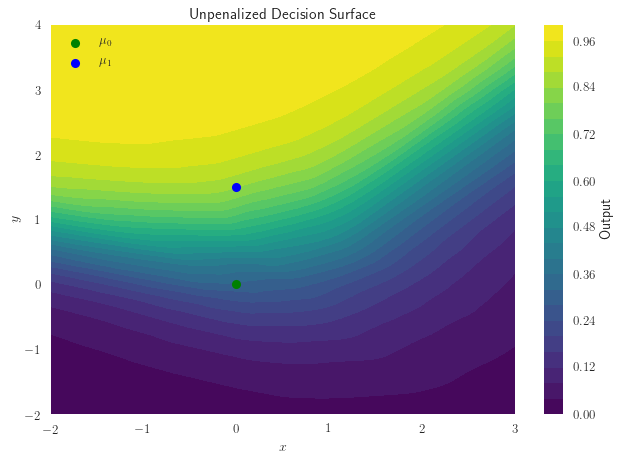

In [21]:
plot_decision_surface(sess, model, title='Unpenalized Decision Surface')

### Switch on MI penalty

In [10]:
sess.close()
args.penalty = True
args.lambda_MI = 1.0
sess_p, model_p, metrics_p = train(args)

Input X shape (512, 2)
Input X shape (512, 2)
joint shape (512, 1)
marginal shape (512, 1)
Classifier Parameters [<tf.Variable 'classifier/fully_connected/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_2/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_2/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/dense/kernel:0' shape=(32, 1) dtype=float32_ref>, <tf.Variable 'classifier/dense/bias:0' shape=(1,) dtype=float32_ref>]
MI-est Parameters [<tf.Variable 'miner/stat_net/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'miner/stat_net/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'miner/stat

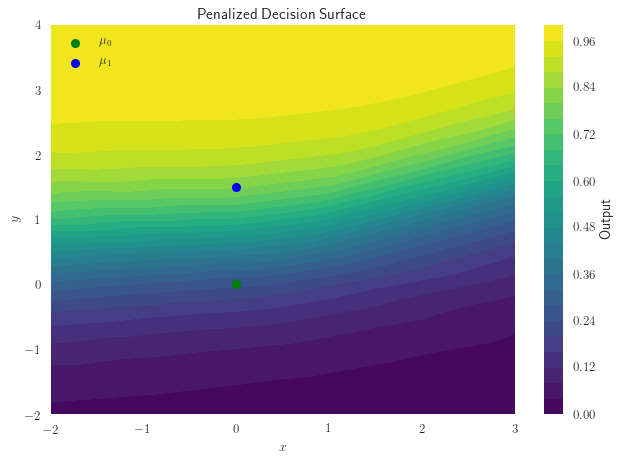

In [11]:
plot_decision_surface(sess_p, model_p, title='Penalized Decision Surface')

### Turn $\lambda$ up a bit

In [12]:
sess_p.close()
args.penalty = True
args.lambda_MI = 10.0
sess_p, model_p, metrics_p = train(args)

Input X shape (512, 2)
Input X shape (512, 2)
joint shape (512, 1)
marginal shape (512, 1)
Classifier Parameters [<tf.Variable 'classifier/fully_connected/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_2/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_2/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/dense/kernel:0' shape=(32, 1) dtype=float32_ref>, <tf.Variable 'classifier/dense/bias:0' shape=(1,) dtype=float32_ref>]
MI-est Parameters [<tf.Variable 'miner/stat_net/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'miner/stat_net/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'miner/stat

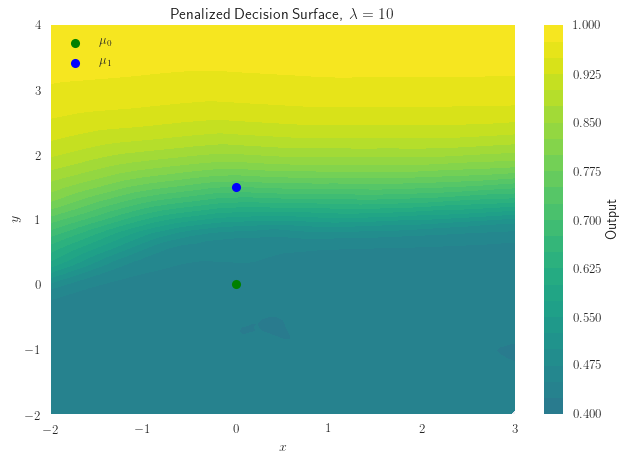

In [13]:
plot_decision_surface(sess_p, model_p, title='Penalized Decision Surface, $\lambda=10$')

### Use KL Loss

In [14]:
sess_p.close()
args.penalty = True
args.lambda_MI = 1.0
args.KL_loss = True
sess_p, model_p, metrics_p_kl = train(args)

Input X shape (512, 2)
Input X shape (512, 2)
joint shape (512, 1)
marginal shape (512, 1)
Classifier Parameters [<tf.Variable 'classifier/fully_connected/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_2/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_2/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/dense/kernel:0' shape=(32, 1) dtype=float32_ref>, <tf.Variable 'classifier/dense/bias:0' shape=(1,) dtype=float32_ref>]
MI-est Parameters [<tf.Variable 'miner/stat_net/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'miner/stat_net/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'miner/stat

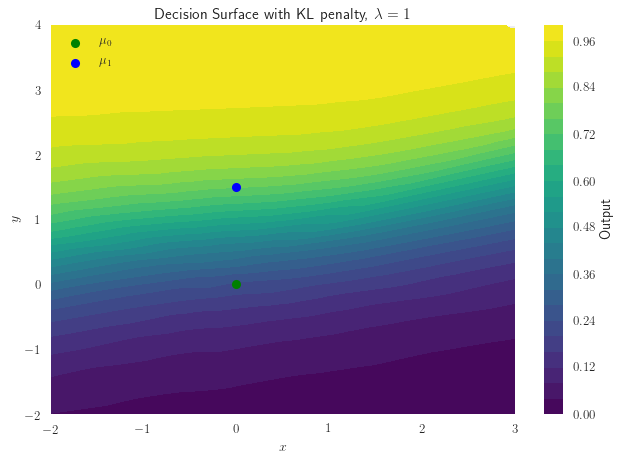

In [15]:
plot_decision_surface(sess_p, model_p, title='Decision Surface with KL penalty, $\lambda=1$')

### Convergence

Look at joint loss, classifier loss, classifier performance.

In [9]:
# No penalty
trials = 25
metric_runs = list()
for _ in range(trials):
    print('Trial: {}'.format(_))
    sess, model, metrics = train(args)
    metric_runs.append(metrics)
    sess.close()
metrics_df = pd.concat(metric_runs)

Trial: 0
Instructions for updating:
Colocations handled automatically by placer.
Input X shape (512, 2)
Instructions for updating:
Use keras.layers.dense instead.
Input X shape (512, 2)
joint shape (512, 1)
marginal shape (512, 1)
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Classifier Parameters [<tf.Variable 'classifier/fully_connected/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected

MI Estimate: -0.003 | kNN: 0.714 | Accuracy: 0.439 | (1.02 s)
MI Estimate: -0.004 | kNN: 0.218 | Accuracy: 0.742 | (1.42 s)
MI Estimate: -0.004 | kNN: 0.122 | Accuracy: 0.787 | (1.71 s)
MI Estimate: -0.006 | kNN: 0.188 | Accuracy: 0.775 | (1.98 s)
MI Estimate: -0.008 | kNN: 0.192 | Accuracy: 0.793 | (2.25 s)
MI Estimate: -0.009 | kNN: 0.172 | Accuracy: 0.771 | (2.55 s)
MI Estimate: -0.009 | kNN: 0.170 | Accuracy: 0.801 | (2.82 s)
MI Estimate: -0.011 | kNN: 0.224 | Accuracy: 0.770 | (3.11 s)
MI Estimate: -0.010 | kNN: 0.181 | Accuracy: 0.797 | (3.39 s)
MI Estimate: -0.009 | kNN: 0.125 | Accuracy: 0.797 | (3.66 s)
MI Estimate: -0.011 | kNN: 0.251 | Accuracy: 0.797 | (3.94 s)
MI Estimate: -0.008 | kNN: 0.147 | Accuracy: 0.773 | (4.21 s)
MI Estimate: -0.010 | kNN: 0.146 | Accuracy: 0.779 | (4.49 s)
MI Estimate: -0.010 | kNN: 0.188 | Accuracy: 0.771 | (4.78 s)
MI Estimate: -0.008 | kNN: 0.178 | Accuracy: 0.768 | (5.06 s)
MI Estimate: -0.009 | kNN: 0.155 | Accuracy: 0.760 | (5.34 s)
MI Estim

MI Estimate: -0.091 | kNN: 0.115 | Accuracy: 0.762 | (8.83 s)
MI Estimate: -0.096 | kNN: 0.142 | Accuracy: 0.781 | (9.12 s)
MI Estimate: -0.092 | kNN: 0.158 | Accuracy: 0.781 | (9.40 s)
MI Estimate: -0.095 | kNN: 0.180 | Accuracy: 0.766 | (9.68 s)
MI Estimate: -0.095 | kNN: 0.122 | Accuracy: 0.791 | (9.96 s)
MI Estimate: -0.093 | kNN: 0.198 | Accuracy: 0.818 | (10.25 s)
MI Estimate: -0.096 | kNN: 0.195 | Accuracy: 0.795 | (10.53 s)
MI Estimate: -0.088 | kNN: 0.232 | Accuracy: 0.768 | (10.81 s)
MI Estimate: -0.092 | kNN: 0.176 | Accuracy: 0.803 | (11.11 s)
MI Estimate: -0.084 | kNN: 0.203 | Accuracy: 0.758 | (11.39 s)
MI Estimate: -0.097 | kNN: 0.247 | Accuracy: 0.795 | (11.67 s)
MI Estimate: -0.086 | kNN: 0.189 | Accuracy: 0.797 | (11.96 s)
MI Estimate: -0.097 | kNN: 0.178 | Accuracy: 0.783 | (12.25 s)
MI Estimate: -0.089 | kNN: 0.208 | Accuracy: 0.758 | (12.53 s)
MI Estimate: -0.092 | kNN: 0.130 | Accuracy: 0.797 | (12.81 s)
MI Estimate: -0.093 | kNN: 0.129 | Accuracy: 0.785 | (13.10 

MI Estimate: -0.042 | kNN: 0.225 | Accuracy: 0.795 | (16.69 s)
MI Estimate: -0.042 | kNN: 0.195 | Accuracy: 0.795 | (16.97 s)
MI Estimate: -0.038 | kNN: 0.181 | Accuracy: 0.805 | (17.25 s)
MI Estimate: -0.038 | kNN: 0.213 | Accuracy: 0.801 | (17.53 s)
MI Estimate: -0.037 | kNN: 0.176 | Accuracy: 0.771 | (17.81 s)
MI Estimate: -0.041 | kNN: 0.189 | Accuracy: 0.789 | (18.09 s)
MI Estimate: -0.045 | kNN: 0.230 | Accuracy: 0.795 | (18.37 s)
MI Estimate: -0.037 | kNN: 0.217 | Accuracy: 0.807 | (18.65 s)
MI Estimate: -0.044 | kNN: 0.146 | Accuracy: 0.791 | (18.92 s)
MI Estimate: -0.039 | kNN: 0.201 | Accuracy: 0.797 | (19.20 s)
MI Estimate: -0.039 | kNN: 0.111 | Accuracy: 0.787 | (19.48 s)
MI Estimate: -0.041 | kNN: 0.243 | Accuracy: 0.795 | (19.76 s)
MI Estimate: -0.037 | kNN: 0.185 | Accuracy: 0.766 | (20.04 s)
MI Estimate: -0.047 | kNN: 0.246 | Accuracy: 0.752 | (20.32 s)
MI Estimate: -0.045 | kNN: 0.147 | Accuracy: 0.773 | (20.59 s)
MI Estimate: -0.043 | kNN: 0.211 | Accuracy: 0.797 | (2

Classifier Parameters [<tf.Variable 'classifier/fully_connected/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_2/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_2/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/dense/kernel:0' shape=(32, 1) dtype=float32_ref>, <tf.Variable 'classifier/dense/bias:0' shape=(1,) dtype=float32_ref>]
MI-est Parameters [<tf.Variable 'miner/stat_net/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'miner/stat_net/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'miner/stat_net/dense_1/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'miner/stat_net/dens

MI Estimate: -0.207 | kNN: 0.166 | Accuracy: 0.752 | (3.18 s)
MI Estimate: -0.215 | kNN: 0.180 | Accuracy: 0.820 | (3.46 s)
MI Estimate: -0.231 | kNN: 0.150 | Accuracy: 0.797 | (3.73 s)
MI Estimate: -0.213 | kNN: 0.145 | Accuracy: 0.811 | (4.01 s)
MI Estimate: -0.242 | kNN: 0.169 | Accuracy: 0.777 | (4.29 s)
MI Estimate: -0.229 | kNN: 0.171 | Accuracy: 0.775 | (4.57 s)
MI Estimate: -0.254 | kNN: 0.127 | Accuracy: 0.771 | (4.85 s)
MI Estimate: -0.233 | kNN: 0.183 | Accuracy: 0.768 | (5.13 s)
MI Estimate: -0.248 | kNN: 0.141 | Accuracy: 0.809 | (5.40 s)
MI Estimate: -0.243 | kNN: 0.197 | Accuracy: 0.766 | (5.68 s)
MI Estimate: -0.236 | kNN: 0.136 | Accuracy: 0.793 | (5.96 s)
MI Estimate: -0.231 | kNN: 0.199 | Accuracy: 0.799 | (6.24 s)
MI Estimate: -0.247 | kNN: 0.169 | Accuracy: 0.770 | (6.52 s)
MI Estimate: -0.245 | kNN: 0.159 | Accuracy: 0.766 | (6.79 s)
MI Estimate: -0.246 | kNN: 0.185 | Accuracy: 0.770 | (7.07 s)
MI Estimate: -0.257 | kNN: 0.161 | Accuracy: 0.787 | (7.35 s)
MI Estim

MI Estimate: -0.048 | kNN: 0.271 | Accuracy: 0.793 | (10.96 s)
MI Estimate: -0.043 | kNN: 0.147 | Accuracy: 0.791 | (11.24 s)
MI Estimate: -0.046 | kNN: 0.201 | Accuracy: 0.777 | (11.52 s)
MI Estimate: -0.042 | kNN: 0.170 | Accuracy: 0.795 | (11.80 s)
MI Estimate: -0.048 | kNN: 0.131 | Accuracy: 0.820 | (12.08 s)
MI Estimate: -0.044 | kNN: 0.146 | Accuracy: 0.766 | (12.36 s)
MI Estimate: -0.050 | kNN: 0.187 | Accuracy: 0.781 | (12.65 s)
MI Estimate: -0.043 | kNN: 0.156 | Accuracy: 0.768 | (12.93 s)
MI Estimate: -0.043 | kNN: 0.210 | Accuracy: 0.801 | (13.21 s)
MI Estimate: -0.044 | kNN: 0.122 | Accuracy: 0.783 | (13.49 s)
MI Estimate: -0.043 | kNN: 0.145 | Accuracy: 0.797 | (13.77 s)
MI Estimate: -0.047 | kNN: 0.198 | Accuracy: 0.795 | (14.05 s)
MI Estimate: -0.048 | kNN: 0.148 | Accuracy: 0.781 | (14.33 s)
MI Estimate: -0.046 | kNN: 0.243 | Accuracy: 0.811 | (14.60 s)
MI Estimate: -0.045 | kNN: 0.193 | Accuracy: 0.793 | (14.88 s)
MI Estimate: -0.046 | kNN: 0.147 | Accuracy: 0.775 | (1

MI Estimate: -0.073 | kNN: 0.146 | Accuracy: 0.799 | (18.70 s)
MI Estimate: -0.066 | kNN: 0.196 | Accuracy: 0.785 | (18.98 s)
MI Estimate: -0.064 | kNN: 0.240 | Accuracy: 0.797 | (19.25 s)
MI Estimate: -0.065 | kNN: 0.160 | Accuracy: 0.791 | (19.54 s)
MI Estimate: -0.069 | kNN: 0.104 | Accuracy: 0.781 | (19.81 s)
MI Estimate: -0.063 | kNN: 0.184 | Accuracy: 0.822 | (20.09 s)
MI Estimate: -0.063 | kNN: 0.148 | Accuracy: 0.773 | (20.37 s)
MI Estimate: -0.069 | kNN: 0.253 | Accuracy: 0.740 | (20.65 s)
MI Estimate: -0.071 | kNN: 0.242 | Accuracy: 0.756 | (20.93 s)
MI Estimate: -0.064 | kNN: 0.203 | Accuracy: 0.812 | (21.20 s)
MI Estimate: -0.067 | kNN: 0.199 | Accuracy: 0.762 | (21.48 s)
MI Estimate: -0.066 | kNN: 0.154 | Accuracy: 0.758 | (21.76 s)
MI Estimate: -0.070 | kNN: 0.186 | Accuracy: 0.799 | (22.04 s)
MI Estimate: -0.086 | kNN: 0.212 | Accuracy: 0.787 | (22.31 s)
MI Estimate: -0.067 | kNN: 0.124 | Accuracy: 0.746 | (22.59 s)
MI Estimate: -0.070 | kNN: 0.234 | Accuracy: 0.779 | (2

MI Estimate: -0.053 | kNN: 0.520 | Accuracy: 0.520 | (1.66 s)
MI Estimate: -0.066 | kNN: 0.190 | Accuracy: 0.738 | (1.96 s)
MI Estimate: -0.066 | kNN: 0.282 | Accuracy: 0.775 | (2.24 s)
MI Estimate: -0.081 | kNN: 0.275 | Accuracy: 0.766 | (2.51 s)
MI Estimate: -0.097 | kNN: 0.275 | Accuracy: 0.758 | (2.79 s)
MI Estimate: -0.112 | kNN: 0.321 | Accuracy: 0.777 | (3.07 s)
MI Estimate: -0.128 | kNN: 0.273 | Accuracy: 0.781 | (3.35 s)
MI Estimate: -0.158 | kNN: 0.240 | Accuracy: 0.781 | (3.62 s)
MI Estimate: -0.170 | kNN: 0.231 | Accuracy: 0.773 | (3.90 s)
MI Estimate: -0.149 | kNN: 0.281 | Accuracy: 0.826 | (4.18 s)
MI Estimate: -0.151 | kNN: 0.260 | Accuracy: 0.752 | (4.46 s)
MI Estimate: -0.166 | kNN: 0.190 | Accuracy: 0.820 | (4.74 s)
MI Estimate: -0.162 | kNN: 0.213 | Accuracy: 0.801 | (5.02 s)
MI Estimate: -0.146 | kNN: 0.189 | Accuracy: 0.773 | (5.30 s)
MI Estimate: -0.165 | kNN: 0.151 | Accuracy: 0.785 | (5.58 s)
MI Estimate: -0.167 | kNN: 0.247 | Accuracy: 0.797 | (5.86 s)
MI Estim

MI Estimate: -0.008 | kNN: 0.246 | Accuracy: 0.814 | (9.71 s)
MI Estimate: -0.008 | kNN: 0.157 | Accuracy: 0.822 | (9.99 s)
MI Estimate: -0.010 | kNN: 0.193 | Accuracy: 0.783 | (10.27 s)
MI Estimate: -0.009 | kNN: 0.200 | Accuracy: 0.773 | (10.55 s)
MI Estimate: -0.004 | kNN: 0.115 | Accuracy: 0.768 | (10.83 s)
MI Estimate: -0.010 | kNN: 0.204 | Accuracy: 0.820 | (11.11 s)
MI Estimate: -0.013 | kNN: 0.197 | Accuracy: 0.824 | (11.39 s)
MI Estimate: -0.005 | kNN: 0.181 | Accuracy: 0.779 | (11.68 s)
MI Estimate: -0.009 | kNN: 0.226 | Accuracy: 0.801 | (11.96 s)
MI Estimate: -0.005 | kNN: 0.188 | Accuracy: 0.736 | (12.24 s)
MI Estimate: -0.006 | kNN: 0.201 | Accuracy: 0.777 | (12.51 s)
MI Estimate: -0.008 | kNN: 0.132 | Accuracy: 0.789 | (12.79 s)
MI Estimate: -0.017 | kNN: 0.231 | Accuracy: 0.809 | (13.07 s)
MI Estimate: -0.002 | kNN: 0.144 | Accuracy: 0.770 | (13.35 s)
MI Estimate: -0.007 | kNN: 0.161 | Accuracy: 0.791 | (13.64 s)
MI Estimate: -0.011 | kNN: 0.172 | Accuracy: 0.824 | (13.

MI Estimate: -0.009 | kNN: 0.136 | Accuracy: 0.818 | (17.32 s)
MI Estimate: -0.010 | kNN: 0.204 | Accuracy: 0.787 | (17.60 s)
MI Estimate: -0.008 | kNN: 0.212 | Accuracy: 0.777 | (17.89 s)
MI Estimate: -0.012 | kNN: 0.209 | Accuracy: 0.791 | (18.17 s)
MI Estimate: -0.010 | kNN: 0.185 | Accuracy: 0.768 | (18.45 s)
MI Estimate: -0.012 | kNN: 0.212 | Accuracy: 0.783 | (18.74 s)
MI Estimate: -0.011 | kNN: 0.218 | Accuracy: 0.773 | (19.01 s)
MI Estimate: -0.007 | kNN: 0.201 | Accuracy: 0.791 | (19.29 s)
MI Estimate: -0.010 | kNN: 0.211 | Accuracy: 0.775 | (19.57 s)
MI Estimate: -0.012 | kNN: 0.188 | Accuracy: 0.795 | (19.85 s)
MI Estimate: -0.011 | kNN: 0.157 | Accuracy: 0.791 | (20.13 s)
MI Estimate: -0.013 | kNN: 0.209 | Accuracy: 0.789 | (20.43 s)
MI Estimate: -0.010 | kNN: 0.208 | Accuracy: 0.791 | (20.70 s)
MI Estimate: -0.010 | kNN: 0.172 | Accuracy: 0.803 | (20.99 s)
MI Estimate: -0.010 | kNN: 0.138 | Accuracy: 0.789 | (21.27 s)
MI Estimate: -0.010 | kNN: 0.184 | Accuracy: 0.789 | (2

Classifier Parameters [<tf.Variable 'classifier/fully_connected/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_2/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_2/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/dense/kernel:0' shape=(32, 1) dtype=float32_ref>, <tf.Variable 'classifier/dense/bias:0' shape=(1,) dtype=float32_ref>]
MI-est Parameters [<tf.Variable 'miner/stat_net/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'miner/stat_net/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'miner/stat_net/dense_1/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'miner/stat_net/dens

MI Estimate: -0.058 | kNN: 0.166 | Accuracy: 0.781 | (3.80 s)
MI Estimate: -0.080 | kNN: 0.278 | Accuracy: 0.770 | (4.07 s)
MI Estimate: -0.073 | kNN: 0.202 | Accuracy: 0.832 | (4.35 s)
MI Estimate: -0.063 | kNN: 0.165 | Accuracy: 0.801 | (4.63 s)
MI Estimate: -0.070 | kNN: 0.198 | Accuracy: 0.775 | (4.91 s)
MI Estimate: -0.074 | kNN: 0.161 | Accuracy: 0.799 | (5.19 s)
MI Estimate: -0.081 | kNN: 0.302 | Accuracy: 0.795 | (5.47 s)
MI Estimate: -0.071 | kNN: 0.176 | Accuracy: 0.764 | (5.75 s)
MI Estimate: -0.060 | kNN: 0.168 | Accuracy: 0.768 | (6.02 s)
MI Estimate: -0.068 | kNN: 0.162 | Accuracy: 0.789 | (6.32 s)
MI Estimate: -0.070 | kNN: 0.183 | Accuracy: 0.785 | (6.59 s)
MI Estimate: -0.071 | kNN: 0.242 | Accuracy: 0.801 | (6.87 s)
MI Estimate: -0.061 | kNN: 0.155 | Accuracy: 0.781 | (7.15 s)
MI Estimate: -0.054 | kNN: 0.172 | Accuracy: 0.781 | (7.42 s)
MI Estimate: -0.067 | kNN: 0.191 | Accuracy: 0.809 | (7.71 s)
MI Estimate: -0.065 | kNN: 0.144 | Accuracy: 0.785 | (7.98 s)
MI Estim

MI Estimate: -0.004 | kNN: 0.148 | Accuracy: 0.805 | (11.88 s)
MI Estimate: -0.003 | kNN: 0.182 | Accuracy: 0.826 | (12.16 s)
MI Estimate: -0.003 | kNN: 0.096 | Accuracy: 0.801 | (12.44 s)
MI Estimate: -0.005 | kNN: 0.151 | Accuracy: 0.803 | (12.72 s)
MI Estimate: -0.002 | kNN: 0.173 | Accuracy: 0.811 | (13.00 s)
MI Estimate: -0.005 | kNN: 0.192 | Accuracy: 0.793 | (13.28 s)
MI Estimate: -0.004 | kNN: 0.172 | Accuracy: 0.803 | (13.56 s)
MI Estimate: -0.002 | kNN: 0.101 | Accuracy: 0.777 | (13.83 s)
MI Estimate: -0.002 | kNN: 0.146 | Accuracy: 0.818 | (14.10 s)
MI Estimate: -0.002 | kNN: 0.170 | Accuracy: 0.775 | (14.39 s)
MI Estimate: -0.004 | kNN: 0.168 | Accuracy: 0.787 | (14.66 s)
MI Estimate: -0.003 | kNN: 0.222 | Accuracy: 0.791 | (14.94 s)
MI Estimate: -0.002 | kNN: 0.148 | Accuracy: 0.787 | (15.22 s)
MI Estimate: -0.003 | kNN: 0.195 | Accuracy: 0.826 | (15.49 s)
MI Estimate: -0.001 | kNN: 0.220 | Accuracy: 0.789 | (15.77 s)
MI Estimate: -0.003 | kNN: 0.224 | Accuracy: 0.771 | (1

MI Estimate: -0.035 | kNN: 0.165 | Accuracy: 0.797 | (19.52 s)
MI Estimate: -0.032 | kNN: 0.096 | Accuracy: 0.791 | (19.81 s)
MI Estimate: -0.031 | kNN: 0.146 | Accuracy: 0.770 | (20.09 s)
MI Estimate: -0.036 | kNN: 0.179 | Accuracy: 0.811 | (20.37 s)
MI Estimate: -0.035 | kNN: 0.217 | Accuracy: 0.771 | (20.65 s)
MI Estimate: -0.035 | kNN: 0.210 | Accuracy: 0.809 | (20.93 s)
MI Estimate: -0.031 | kNN: 0.157 | Accuracy: 0.773 | (21.20 s)
MI Estimate: -0.035 | kNN: 0.149 | Accuracy: 0.783 | (21.48 s)
MI Estimate: -0.032 | kNN: 0.232 | Accuracy: 0.789 | (21.75 s)
MI Estimate: -0.034 | kNN: 0.269 | Accuracy: 0.803 | (22.03 s)
MI Estimate: -0.031 | kNN: 0.174 | Accuracy: 0.773 | (22.31 s)
MI Estimate: -0.033 | kNN: 0.157 | Accuracy: 0.791 | (22.58 s)
MI Estimate: -0.032 | kNN: 0.137 | Accuracy: 0.783 | (22.86 s)
MI Estimate: -0.032 | kNN: 0.131 | Accuracy: 0.812 | (23.14 s)
MI Estimate: -0.030 | kNN: 0.143 | Accuracy: 0.783 | (23.43 s)
MI Estimate: -0.032 | kNN: 0.141 | Accuracy: 0.766 | (2

MI Estimate: -0.073 | kNN: 0.843 | Accuracy: 0.459 | (2.55 s)
MI Estimate: -0.065 | kNN: 0.255 | Accuracy: 0.662 | (2.83 s)
MI Estimate: -0.064 | kNN: 0.117 | Accuracy: 0.752 | (3.10 s)
MI Estimate: -0.079 | kNN: 0.130 | Accuracy: 0.785 | (3.38 s)
MI Estimate: -0.075 | kNN: 0.169 | Accuracy: 0.748 | (3.66 s)
MI Estimate: -0.073 | kNN: 0.197 | Accuracy: 0.758 | (3.94 s)
MI Estimate: -0.071 | kNN: 0.161 | Accuracy: 0.777 | (4.21 s)
MI Estimate: -0.073 | kNN: 0.133 | Accuracy: 0.789 | (4.50 s)
MI Estimate: -0.072 | kNN: 0.098 | Accuracy: 0.785 | (4.78 s)
MI Estimate: -0.077 | kNN: 0.138 | Accuracy: 0.826 | (5.06 s)
MI Estimate: -0.076 | kNN: 0.151 | Accuracy: 0.775 | (5.34 s)
MI Estimate: -0.080 | kNN: 0.206 | Accuracy: 0.814 | (5.61 s)
MI Estimate: -0.081 | kNN: 0.171 | Accuracy: 0.803 | (5.89 s)
MI Estimate: -0.079 | kNN: 0.254 | Accuracy: 0.797 | (6.17 s)
MI Estimate: -0.075 | kNN: 0.169 | Accuracy: 0.783 | (6.45 s)
MI Estimate: -0.080 | kNN: 0.085 | Accuracy: 0.775 | (6.72 s)
MI Estim

MI Estimate: -0.042 | kNN: 0.267 | Accuracy: 0.805 | (10.69 s)
MI Estimate: -0.044 | kNN: 0.144 | Accuracy: 0.783 | (10.99 s)
MI Estimate: -0.039 | kNN: 0.180 | Accuracy: 0.791 | (11.27 s)
MI Estimate: -0.038 | kNN: 0.188 | Accuracy: 0.785 | (11.55 s)
MI Estimate: -0.040 | kNN: 0.176 | Accuracy: 0.793 | (11.83 s)
MI Estimate: -0.041 | kNN: 0.134 | Accuracy: 0.779 | (12.11 s)
MI Estimate: -0.042 | kNN: 0.130 | Accuracy: 0.764 | (12.39 s)
MI Estimate: -0.040 | kNN: 0.160 | Accuracy: 0.775 | (12.67 s)
MI Estimate: -0.048 | kNN: 0.208 | Accuracy: 0.801 | (12.94 s)
MI Estimate: -0.043 | kNN: 0.188 | Accuracy: 0.799 | (13.22 s)
MI Estimate: -0.039 | kNN: 0.157 | Accuracy: 0.783 | (13.51 s)
MI Estimate: -0.034 | kNN: 0.169 | Accuracy: 0.764 | (13.79 s)
MI Estimate: -0.036 | kNN: 0.081 | Accuracy: 0.791 | (14.07 s)
MI Estimate: -0.038 | kNN: 0.208 | Accuracy: 0.791 | (14.36 s)
MI Estimate: -0.038 | kNN: 0.158 | Accuracy: 0.824 | (14.64 s)
MI Estimate: -0.039 | kNN: 0.111 | Accuracy: 0.791 | (1

MI Estimate: -0.131 | kNN: 0.178 | Accuracy: 0.805 | (18.55 s)
MI Estimate: -0.136 | kNN: 0.132 | Accuracy: 0.752 | (18.83 s)
MI Estimate: -0.134 | kNN: 0.224 | Accuracy: 0.779 | (19.10 s)
MI Estimate: -0.130 | kNN: 0.165 | Accuracy: 0.818 | (19.38 s)
MI Estimate: -0.121 | kNN: 0.255 | Accuracy: 0.789 | (19.66 s)
MI Estimate: -0.121 | kNN: 0.193 | Accuracy: 0.785 | (19.93 s)
MI Estimate: -0.127 | kNN: 0.174 | Accuracy: 0.803 | (20.23 s)
MI Estimate: -0.115 | kNN: 0.167 | Accuracy: 0.781 | (20.51 s)
MI Estimate: -0.126 | kNN: 0.184 | Accuracy: 0.779 | (20.79 s)
MI Estimate: -0.125 | kNN: 0.104 | Accuracy: 0.770 | (21.07 s)
MI Estimate: -0.121 | kNN: 0.219 | Accuracy: 0.760 | (21.34 s)
MI Estimate: -0.119 | kNN: 0.213 | Accuracy: 0.812 | (21.62 s)
MI Estimate: -0.136 | kNN: 0.143 | Accuracy: 0.811 | (21.89 s)
MI Estimate: -0.122 | kNN: 0.144 | Accuracy: 0.797 | (22.19 s)
MI Estimate: -0.141 | kNN: 0.152 | Accuracy: 0.809 | (22.47 s)
MI Estimate: -0.130 | kNN: 0.229 | Accuracy: 0.811 | (2

Classifier Parameters [<tf.Variable 'classifier/fully_connected/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_2/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_2/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/dense/kernel:0' shape=(32, 1) dtype=float32_ref>, <tf.Variable 'classifier/dense/bias:0' shape=(1,) dtype=float32_ref>]
MI-est Parameters [<tf.Variable 'miner/stat_net/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'miner/stat_net/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'miner/stat_net/dense_1/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'miner/stat_net/dens

MI Estimate: -0.002 | kNN: 0.086 | Accuracy: 0.777 | (4.88 s)
MI Estimate: -0.003 | kNN: 0.180 | Accuracy: 0.783 | (5.16 s)
MI Estimate: -0.005 | kNN: 0.151 | Accuracy: 0.797 | (5.45 s)
MI Estimate: -0.005 | kNN: 0.217 | Accuracy: 0.771 | (5.73 s)
MI Estimate: -0.006 | kNN: 0.125 | Accuracy: 0.764 | (6.00 s)
MI Estimate: -0.001 | kNN: 0.219 | Accuracy: 0.807 | (6.28 s)
MI Estimate: -0.004 | kNN: 0.261 | Accuracy: 0.777 | (6.56 s)
MI Estimate: -0.004 | kNN: 0.203 | Accuracy: 0.791 | (6.84 s)
MI Estimate: -0.006 | kNN: 0.127 | Accuracy: 0.818 | (7.14 s)
MI Estimate: -0.003 | kNN: 0.160 | Accuracy: 0.805 | (7.43 s)
MI Estimate: -0.003 | kNN: 0.220 | Accuracy: 0.773 | (7.71 s)
MI Estimate: -0.002 | kNN: 0.139 | Accuracy: 0.781 | (8.00 s)
MI Estimate: -0.005 | kNN: 0.158 | Accuracy: 0.764 | (8.27 s)
MI Estimate: -0.005 | kNN: 0.195 | Accuracy: 0.758 | (8.55 s)
MI Estimate: -0.002 | kNN: 0.181 | Accuracy: 0.797 | (8.83 s)
MI Estimate: -0.004 | kNN: 0.149 | Accuracy: 0.799 | (9.11 s)
MI Estim

In [ ]:
sess.close()
args.penalty = True
args.lambda_MI = 1.0
metric_runs = list()
for _ in range(trials):
    print('Trial: {}'.format(_))
    sess_p, model_p, metrics_p = train(args)
    metric_runs.append(metrics_p)
    sess_p.close()
metrics_p_df = pd.concat(metric_runs)

Trial: 0
Input X shape (512, 2)
Input X shape (512, 2)
joint shape (512, 1)
marginal shape (512, 1)
Classifier Parameters [<tf.Variable 'classifier/fully_connected/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_1/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_2/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'classifier/fully_connected/dense_2/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'classifier/dense/kernel:0' shape=(32, 1) dtype=float32_ref>, <tf.Variable 'classifier/dense/bias:0' shape=(1,) dtype=float32_ref>]
MI-est Parameters [<tf.Variable 'miner/stat_net/dense/kernel:0' shape=(2, 32) dtype=float32_ref>, <tf.Variable 'miner/stat_net/dense/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'm

/usr/local/easybuild/software/Tensorflow/1.13.1-intel-2017.u2-GCC-6.2.0-CUDA10-Python-3.6.4-GPU/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


MI Estimate: -0.000 | kNN: 0.232 | Accuracy: 0.486 | (7.71 s)
MI Estimate: 0.015 | kNN: 0.081 | Accuracy: 0.430 | (9.08 s)
MI Estimate: -0.000 | kNN: 0.187 | Accuracy: 0.705 | (10.35 s)
MI Estimate: 0.001 | kNN: 0.094 | Accuracy: 0.703 | (11.62 s)
MI Estimate: 0.005 | kNN: 0.125 | Accuracy: 0.736 | (12.89 s)
MI Estimate: 0.017 | kNN: 0.050 | Accuracy: 0.727 | (14.17 s)
MI Estimate: 0.013 | kNN: 0.099 | Accuracy: 0.764 | (15.43 s)
MI Estimate: 0.028 | kNN: 0.067 | Accuracy: 0.768 | (16.70 s)
MI Estimate: 0.005 | kNN: 0.035 | Accuracy: 0.762 | (17.96 s)
MI Estimate: 0.025 | kNN: 0.059 | Accuracy: 0.809 | (19.23 s)
MI Estimate: 0.019 | kNN: 0.054 | Accuracy: 0.797 | (20.48 s)
MI Estimate: 0.016 | kNN: 0.105 | Accuracy: 0.771 | (21.74 s)
MI Estimate: 0.017 | kNN: 0.039 | Accuracy: 0.746 | (23.01 s)
MI Estimate: 0.021 | kNN: 0.063 | Accuracy: 0.773 | (24.28 s)
MI Estimate: 0.026 | kNN: 0.074 | Accuracy: 0.785 | (25.55 s)
MI Estimate: -0.004 | kNN: 0.085 | Accuracy: 0.771 | (26.81 s)
MI Esti

/usr/local/easybuild/software/Tensorflow/1.13.1-intel-2017.u2-GCC-6.2.0-CUDA10-Python-3.6.4-GPU/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


MI Estimate: 0.002 | kNN: 0.654 | Accuracy: 0.555 | (7.84 s)
MI Estimate: 0.001 | kNN: 0.153 | Accuracy: 0.531 | (9.21 s)
MI Estimate: 0.012 | kNN: 0.071 | Accuracy: 0.572 | (10.49 s)
MI Estimate: 0.009 | kNN: 0.046 | Accuracy: 0.682 | (11.76 s)
MI Estimate: 0.003 | kNN: -0.026 | Accuracy: 0.730 | (13.02 s)
MI Estimate: -0.003 | kNN: 0.038 | Accuracy: 0.746 | (14.30 s)
MI Estimate: 0.009 | kNN: 0.088 | Accuracy: 0.752 | (15.57 s)
MI Estimate: 0.009 | kNN: 0.045 | Accuracy: 0.779 | (16.84 s)
MI Estimate: 0.012 | kNN: 0.025 | Accuracy: 0.789 | (18.11 s)
MI Estimate: 0.007 | kNN: 0.025 | Accuracy: 0.781 | (19.39 s)
MI Estimate: 0.012 | kNN: 0.079 | Accuracy: 0.805 | (20.67 s)
MI Estimate: 0.017 | kNN: 0.078 | Accuracy: 0.805 | (21.92 s)
MI Estimate: 0.022 | kNN: 0.084 | Accuracy: 0.783 | (23.20 s)
MI Estimate: 0.026 | kNN: 0.115 | Accuracy: 0.781 | (24.45 s)
MI Estimate: 0.007 | kNN: 0.083 | Accuracy: 0.781 | (25.71 s)
MI Estimate: 0.022 | kNN: 0.098 | Accuracy: 0.803 | (26.98 s)
MI Estim

/usr/local/easybuild/software/Tensorflow/1.13.1-intel-2017.u2-GCC-6.2.0-CUDA10-Python-3.6.4-GPU/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


MI Estimate: 0.002 | kNN: 0.349 | Accuracy: 0.617 | (8.05 s)
MI Estimate: 0.034 | kNN: 0.135 | Accuracy: 0.713 | (9.43 s)
MI Estimate: 0.017 | kNN: 0.079 | Accuracy: 0.787 | (10.71 s)
MI Estimate: 0.018 | kNN: 0.085 | Accuracy: 0.785 | (11.98 s)
MI Estimate: 0.032 | kNN: 0.062 | Accuracy: 0.781 | (13.24 s)
MI Estimate: 0.023 | kNN: 0.117 | Accuracy: 0.771 | (14.50 s)
MI Estimate: 0.021 | kNN: 0.086 | Accuracy: 0.793 | (15.76 s)
MI Estimate: 0.014 | kNN: 0.086 | Accuracy: 0.787 | (17.02 s)
MI Estimate: 0.010 | kNN: 0.047 | Accuracy: 0.762 | (18.28 s)
MI Estimate: 0.013 | kNN: 0.018 | Accuracy: 0.787 | (19.54 s)
MI Estimate: 0.003 | kNN: 0.011 | Accuracy: 0.785 | (20.80 s)
MI Estimate: 0.010 | kNN: 0.133 | Accuracy: 0.801 | (22.06 s)
MI Estimate: 0.022 | kNN: 0.022 | Accuracy: 0.787 | (23.32 s)
MI Estimate: 0.014 | kNN: 0.033 | Accuracy: 0.824 | (24.58 s)
MI Estimate: 0.006 | kNN: 0.034 | Accuracy: 0.752 | (25.84 s)
MI Estimate: 0.010 | kNN: 0.049 | Accuracy: 0.773 | (27.10 s)
MI Estimat

/usr/local/easybuild/software/Tensorflow/1.13.1-intel-2017.u2-GCC-6.2.0-CUDA10-Python-3.6.4-GPU/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


MI Estimate: -0.002 | kNN: 0.334 | Accuracy: 0.771 | (8.23 s)
MI Estimate: 0.018 | kNN: 0.061 | Accuracy: 0.713 | (9.61 s)
MI Estimate: 0.010 | kNN: 0.026 | Accuracy: 0.734 | (10.90 s)
MI Estimate: 0.017 | kNN: 0.083 | Accuracy: 0.777 | (12.17 s)
MI Estimate: 0.025 | kNN: 0.060 | Accuracy: 0.807 | (13.44 s)
MI Estimate: 0.023 | kNN: 0.154 | Accuracy: 0.744 | (14.69 s)
MI Estimate: 0.012 | kNN: 0.109 | Accuracy: 0.744 | (15.95 s)
MI Estimate: 0.012 | kNN: 0.114 | Accuracy: 0.799 | (17.22 s)
MI Estimate: 0.003 | kNN: 0.086 | Accuracy: 0.785 | (18.49 s)
MI Estimate: 0.022 | kNN: 0.047 | Accuracy: 0.801 | (19.76 s)
MI Estimate: 0.019 | kNN: 0.060 | Accuracy: 0.781 | (21.02 s)
MI Estimate: 0.015 | kNN: 0.098 | Accuracy: 0.766 | (22.28 s)
MI Estimate: 0.019 | kNN: 0.075 | Accuracy: 0.797 | (23.55 s)
MI Estimate: 0.014 | kNN: 0.052 | Accuracy: 0.793 | (24.81 s)
MI Estimate: 0.012 | kNN: 0.030 | Accuracy: 0.760 | (26.06 s)
MI Estimate: 0.013 | kNN: 0.032 | Accuracy: 0.770 | (27.33 s)
MI Estima

In [ ]:
sess_p.close()
args.penalty = True
args.lambda_MI = 1.0
args.KL_loss = True
metric_runs = list()
for _ in range(trials):
    print('Trial: {}'.format(_))
    sess_p, model_p, metrics_p = train(args)
    metric_runs.append(metrics_p)
    sess_p.close()
metrics_p_kl_df = pd.concat(metric_runs)

In [ ]:
sess_p.close()
args.penalty = True
args.lambda_MI = 10.0
args.KL_loss = True
metric_runs = list()
for _ in range(trials):
    print('Trial: {}'.format(_))
    sess_p, model_p, metrics_p = train(args)
    metric_runs.append(metrics_p)
    sess_p.close()
metrics_p10_df = pd.concat(metric_runs)

In [ ]:
sess_p.close()
args.penalty = True
args.lambda_MI = 10.0
args.KL_loss = False
metric_runs = list()
for _ in range(trials):
    print('Trial: {}'.format(_))
    sess_p, model_p, metrics_p = train(args)
    metric_runs.append(metrics_p)
    sess_p.close()
metrics_p10_df_kl = pd.concat(metric_runs)

/home/jtan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


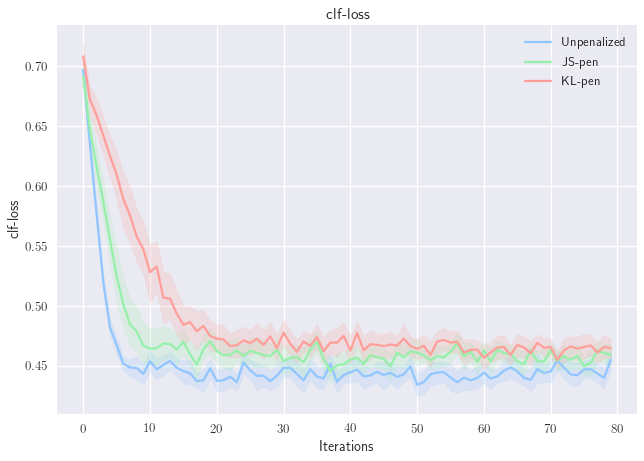

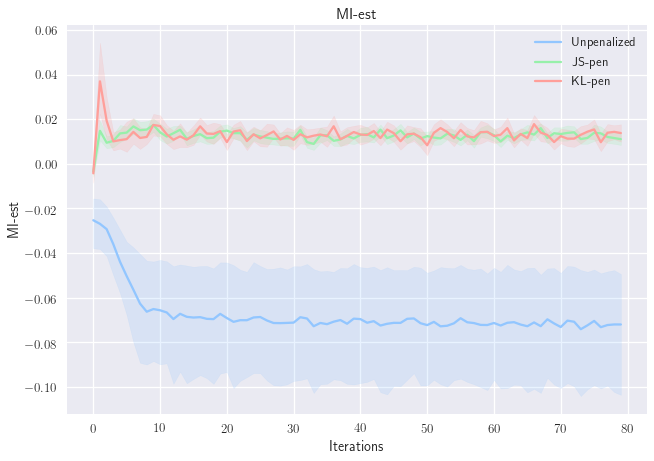

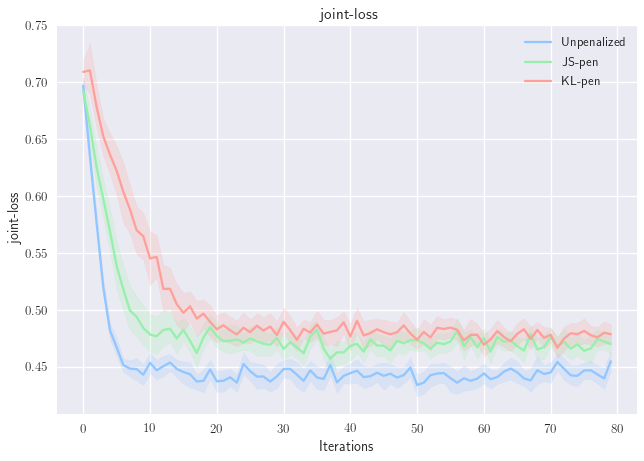

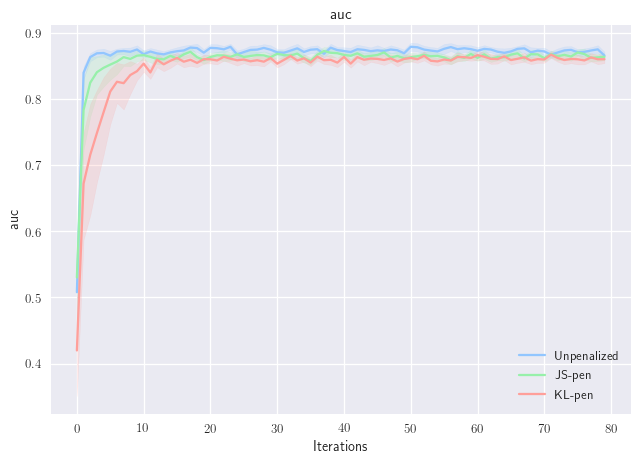

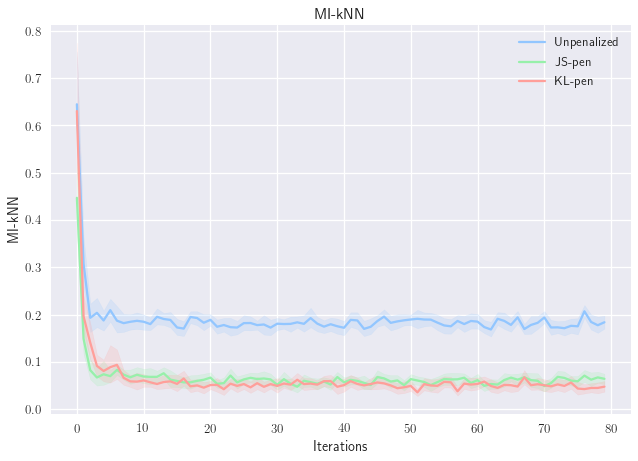

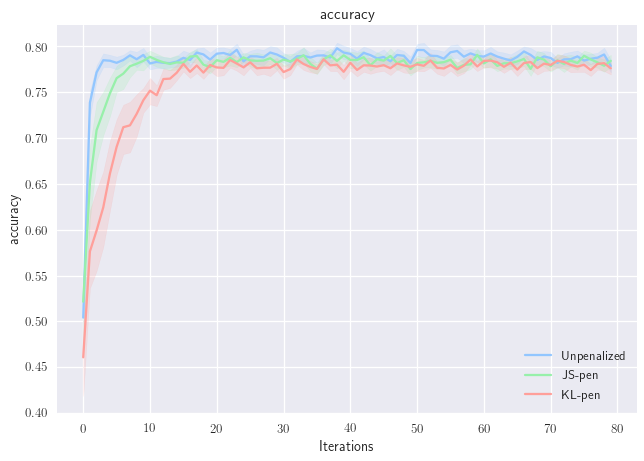

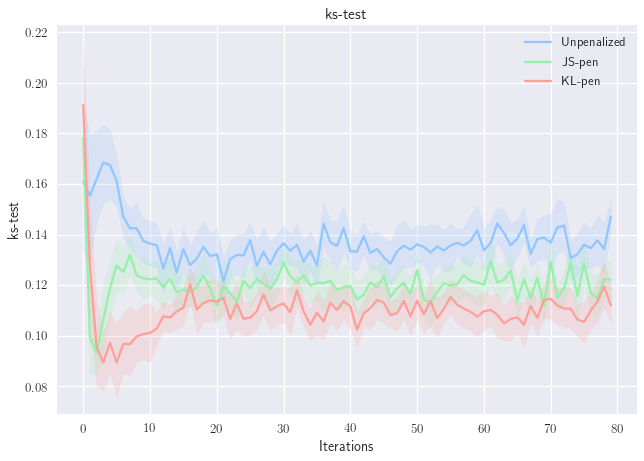

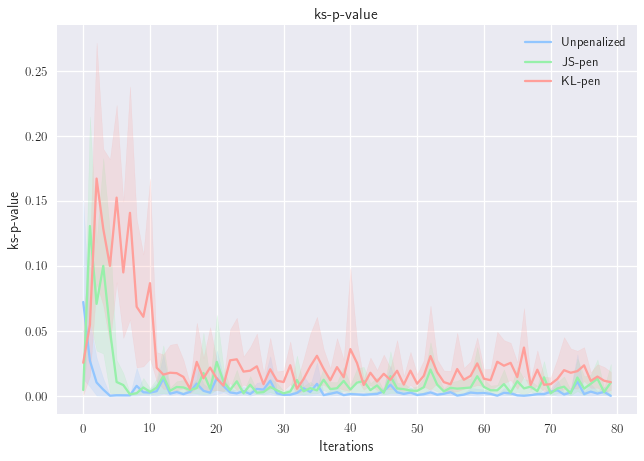

In [79]:
# Convergence plots
smooth = lambda df: df.rolling(window=2, center=True).mean().dropna()
for col in metrics_df.columns:
    plt.figure()
    sns.lineplot(x=metrics_df.index, y=col, data=metrics_df, label='Unpenalized')
    sns.lineplot(x=metrics_p_df.index, y=col, data=metrics_p_df, label='JS-pen')
    sns.lineplot(x=metrics_p_kl_df.index, y=col, data=metrics_p_kl_df, label='KL-pen')
    plt.title(col)
    plt.legend(loc='best')
    plt.xlabel('Iterations')